In [1]:
!ls

Data Cleaning, Visualization and Validation.ipynb


In [1]:
import h5py
from pynwb import NWBHDF5IO

def load_nwb_file(filepath):
    io = NWBHDF5IO(filepath, 'r')
    nwbfile = io.read()
    io.close()
    return nwbfile

In [2]:
base_path = "/Users/williamdiaz/Downloads/ano/000535/"

nwbfile = load_nwb_file(base_path + "sub-509643/sub-509643_ses-20200615T193944_behavior+ophys.nwb")
print(nwbfile)

root pynwb.file.NWBFile at 0x5107266080
Fields:
  devices: {
    2p_microscope <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2023, 5, 16, 10, 26, 3, 949243, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=61200)))]
  identifier: 1030103176
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: Allen Institute OpenScope dataset
  session_start_time: 2020-06-15 19:39:44.575000-07:00
  subject: subject pynwb.file.Subject at 0x5106964896
Fields:
  age__reference: birth
  date_of_birth: 2019-12-12 16:00:00-08:00
  genotype: Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
  sex: M
  species: Mus musculus
  subject_id: 509643

  timestamps_reference_time: 2020-06-15 19:39:44.575000-07:00
  trials: trials <class 'pynwb.epoch.TimeI

/Users/williamdiaz/Downloads/ano/venv/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/williamdiaz/Downloads/ano/venv/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/williamdiaz/Downloads/ano/venv/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [3]:
def load_neural_data_from_nwb(filepath):
    with NWBHDF5IO(filepath, 'r') as io:
        nwbfile = io.read()
        print(nwbfile.intervals['trials'].colnames)

        # Access the 'ophys' processing module
        ophys_module = nwbfile.processing['ophys']
        # Access the 'DfOverF' interface and then the 'RoiResponseSeries'
        df_over_f = ophys_module['DfOverF']
        roi_response_series = df_over_f['RoiResponseSeries']
        neural_data = roi_response_series.data[:]
        return neural_data

neural_data = load_neural_data_from_nwb(base_path + "sub-509643/sub-509643_ses-20200615T193944_behavior+ophys.nwb")
print(neural_data)

('start_time', 'stop_time', 'stimulus')
[[ 0.07379593  0.39555292  0.18513375 ...  0.21444538  0.04056976
   0.13052233]
 [ 0.19639436  0.3411129   0.27879352 ...  0.10109728  0.15490459
   0.23185679]
 [ 0.2100083   0.22593885  0.21030971 ...  0.12995313  0.01929509
   0.19782119]
 ...
 [ 0.06580891  0.15696981  0.07192555 ...  0.23019806  0.1950217
   0.08355783]
 [ 0.1381079   0.2028617   0.20458666 ...  0.1082826  -0.00709072
   0.14290303]
 [ 0.01864628  0.22055629  0.29949462 ...  0.20211127  0.18694162
   0.13404166]]


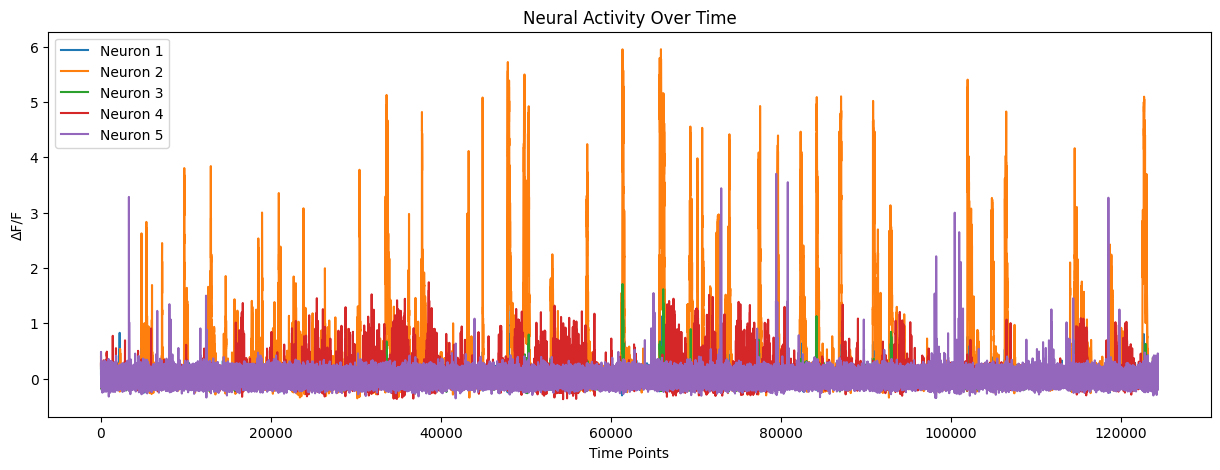

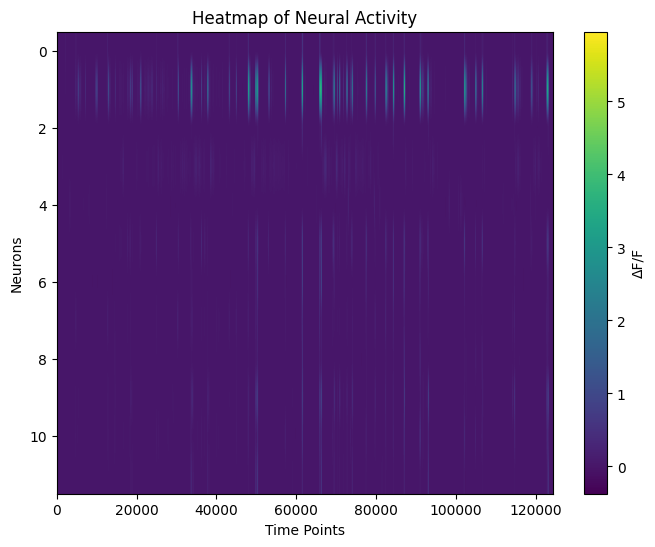

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the activity of the first few neurons
plt.figure(figsize=(15, 5))
time_points = np.arange(neural_data.shape[0])
plt.plot(time_points, neural_data[:, :5])  # Plot the first 5 neurons
plt.title('Neural Activity Over Time')
plt.xlabel('Time Points')
plt.ylabel('ΔF/F')
plt.legend([f'Neuron {i+1}' for i in range(5)])
plt.show()

# Creating a simple heatmap of neural activity
plt.figure(figsize=(8, 6))
plt.imshow(neural_data.T, aspect='auto', cmap='viridis')
plt.colorbar(label='ΔF/F')
plt.title('Heatmap of Neural Activity')
plt.xlabel('Time Points')
plt.ylabel('Neurons')
plt.show()


In [5]:
# Load the data set 

import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data_and_labels(filepath):
    with NWBHDF5IO(filepath, 'r') as io:
        nwbfile = io.read()
        # Extract neural data
        ophys_module = nwbfile.processing['ophys']
        df_over_f = ophys_module['DfOverF']
        roi_response_series = df_over_f['RoiResponseSeries']
        neural_data = roi_response_series.data[:]
        
        # Extract labels
        trials = nwbfile.intervals['trials']
        labels = trials['stimulus'].data[:]
        
        labels = np.full((neural_data.shape[0],), labels[0])  # Fill an array with the label to match neural data length
        
        return neural_data, labels



In [6]:
def calculate_adjusted_percentile_length(base_path, percentile=95):
    lengths = []
    for subdir, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.nwb'):
                filepath = os.path.join(subdir, file)
                with NWBHDF5IO(filepath, 'r') as io:
                    nwbfile = io.read()
                    df_over_f = nwbfile.processing['ophys']['DfOverF']['RoiResponseSeries']
                    lengths.append(df_over_f.data[:].shape[0])
    return int(np.percentile(lengths, percentile))

# Calculate a more practical max_length using a lower percentile
practical_max_length = calculate_adjusted_percentile_length("/Users/williamdiaz/Downloads/ano/000535/")
print(f"Adjusted max trial length (85th percentile): {practical_max_length}")

/Users/williamdiaz/Downloads/ano/venv/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/williamdiaz/Downloads/ano/venv/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/williamdiaz/Downloads/ano/venv/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


Adjusted max trial length (85th percentile): 124351


In [7]:
def calculate_average_neurons(base_path):
    neuron_counts = []
    for subdir, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.nwb'):
                filepath = os.path.join(subdir, file)
                with NWBHDF5IO(filepath, 'r') as io:
                    nwbfile = io.read()
                    df_over_f = nwbfile.processing['ophys']['DfOverF']['RoiResponseSeries']
                    neuron_counts.append(df_over_f.data[:].shape[1])
    return np.mean(neuron_counts)

average_neurons = int(calculate_average_neurons("/Users/williamdiaz/Downloads/ano/000535/"))
print(f"Average number of neurons: {average_neurons}")


def load_dataset_from_directory(base_path, max_length, max_neurons):
    neural_data_list = []
    labels_list = []

    for subdir, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.nwb'):
                filepath = os.path.join(subdir, file)
                with NWBHDF5IO(filepath, 'r') as io:
                    nwbfile = io.read()
                    df_over_f = nwbfile.processing['ophys']['DfOverF']['RoiResponseSeries']
                    neural_data = df_over_f.data[:]
                    
                    # Truncate or pad neurons dimension
                    if neural_data.shape[1] > max_neurons:
                        neural_data = neural_data[:, :max_neurons]
                    elif neural_data.shape[1] < max_neurons:
                        neural_data = np.pad(neural_data, ((0, 0), (0, max_neurons - neural_data.shape[1])), 'constant')

                    # Truncate or pad time points dimension
                    if neural_data.shape[0] > max_length:
                        neural_data = neural_data[:max_length, :]  # Truncate extra time points
                    elif neural_data.shape[0] < max_length:
                        neural_data = np.pad(neural_data, ((0, max_length - neural_data.shape[0]), (0, 0)), 'constant')
                    
                    trials = nwbfile.intervals['trials']
                    labels = np.full((max_length,), trials['stimulus'].data[0])  # Fill labels to match padded length
                    
                    neural_data_list.append(neural_data)
                    labels_list.append(labels)

    neural_data_array = np.vstack(neural_data_list)
    labels_array = np.concatenate(labels_list, axis=0)
    return neural_data_array, labels_array

# Use the new function to load data with the calculated average number of neurons
neural_data, labels = load_dataset_from_directory("/Users/williamdiaz/Downloads/ano/000535/", practical_max_length, average_neurons)
print(f"Neural data shape after processing: {neural_data.shape}")
print(f"Labels shape after processing: {labels.shape}")




Average number of neurons: 43
Neural data shape after processing: (14300365, 43)
Labels shape after processing: (14300365,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Load and encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(neural_data, labels_encoded, test_size=0.10, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Ensure labels are long type for CrossEntropyLoss and expand to match sequence length
y_train = torch.tensor(y_train, dtype=torch.long).repeat_interleave(practical_max_length, dim=0)
y_test = torch.tensor(y_test, dtype=torch.long).repeat_interleave(practical_max_length, dim=0)

# Normalize the input data
X_train_mean = X_train.mean(dim=0, keepdim=True)
X_train_std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# Reshape tensors to fit the model
num_samples_train = X_train.size(0) // practical_max_length
num_samples_test = X_test.size(0) // practical_max_length

X_train = X_train[:num_samples_train * practical_max_length].view(num_samples_train, practical_max_length, 43)
X_test = X_test[:num_samples_test * practical_max_length].view(num_samples_test, practical_max_length, 43)

y_train = y_train[:num_samples_train * practical_max_length].view(num_samples_train, practical_max_length)
y_test = y_test[:num_samples_test * practical_max_length].view(num_samples_test, practical_max_length)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

# Define the LSTM model with dropout
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.1):
        super(SimpleLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob if layer_dim > 1 else 0.0)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Apply dropout and reshape to (batch_size * seq_length, hidden_dim) for fc layer
        out = self.dropout(out.contiguous().view(-1, self.hidden_dim))  
        
        # Apply fully connected layer (batch_size * seq_length, output_dim)
        out = self.fc(out)
        
        # Reshape to (batch_size, seq_length, output_dim) for compatibility with CrossEntropyLoss
        out = out.view(x.size(0), x.size(1), -1)
        return out

# Instantiate the model with dropout
dropout_prob = 0.5
input_dim = 43   # input dimension
hidden_dim = 100 # hidden layer dimension
layer_dim = 1    # number of LSTM layers
output_dim = 4   # output dimension (number of stimulus conditions)

model = SimpleLSTM(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Define the training function with gradient clipping
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Training the model
train_model(model, train_loader, criterion, optimizer)


Epoch [1/10], Step [1/2], Loss: nan


KeyboardInterrupt: 

In [ ]:


# Define the evaluation function
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 2)  # Get the predictions along the last dimension
            total += labels.size(0) * labels.size(1)  # Total number of timesteps
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test set: {100 * correct / total} %')

# Evaluate the model
evaluate_model(model, test_loader)